## Off line exact probabilities 2

In [2]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr

epsilon = 10e-80

In [204]:
def single_p(Tp, Tt, tau_z):
    m = (1 - np.exp(-Tp / tau_z))
    f = np.exp(-(Tt - Tp) / tau_z)
    
    p = Tp - tau_z * m * f
    
    return p / Tt

def probability(tau_z, Tp, Tstart, Ttotal):

    p = Tp - tau_z * np.exp((Tstart - Ttotal)/tau_z) * (np.exp(Tp / tau_z) - 1)

    return p / Ttotal

def joint_probabilities(T1, Ts, T2, Tt, tau1, tau2):
    tau_p = tau1 * tau2 / (tau1 + tau2)
    M1  = 1 - np.exp(-T1 / tau1)
    M2 = 1 - np.exp(-T2 / tau2)
    
    aux1 = M1 * tau1 * (np.exp(-(Ts - T1)/tau1) - np.exp(-(Ts + T2 - T1)/tau1))
    aux2 = M1 * tau_p * np.exp(T1 / tau1) * np.exp(Ts / tau2) * (np.exp(-(Ts + T2)/tau_p) - np.exp(-Ts/tau_p))
    aux3 = M1 * M2 * tau_p * np.exp(T1 / tau1) * np.exp((Ts + T2)/tau2) * (np.exp(-(Tt/tau_p)) - np.exp(-(Ts + T2)/tau_p))
    
    P_aux = aux1 + aux2 - aux3 

    return P_aux / Tt

def self_probability(T1, Tt, tau1, tau2):
    tau_p = tau1 * tau2 / (tau1 + tau2)

    M1  = 1 - np.exp(-T1 / tau1)
    M2 = 1 - np.exp(-T1 / tau2)
    Mp = 1 - np.exp(-T1 / tau_p)

    aux1 = T1 - tau1 * M1 - tau2 * M2 + tau_p * Mp
    aux2 = tau_p * M1 * M2 * (1 - np.exp(-(Tt - T1)/tau_p))
    
    P_self = aux1 + aux2
 
    return P_self / Tt

def get_weights_theo(T1, T2, Tt, tau1, tau2):
  
    Ts = T1
    
    pij = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)
    pji = joint_probabilities(T2, Ts, T1, Tt, tau2, tau1)
    pii = self_probability(T1, Tt, tau1, tau2)

    Ts  = 2 * T1
    pik = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)

    Tp = T1
    pi = single_p(Tp, Tt, tau1)
    Tp = T2
    pj = single_p(Tp, Tt, tau2)

    Tp = T2
    pk = single_p(Tp, Tt, tau2)

    w_self = np.log10(pii / (pi * pi))
    w_next = np.log10(pij / (pi * pj))
    w_rest = np.log10(pik/(pi * pk))
    w_back = np.log10(pji/(pi * pj))
    
    return w_self, w_next, w_rest, w_back

In [49]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 1.0
T_cue = 0.020

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                  tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                  diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

nr = build_network_representation(matrix, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_total, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

In [50]:
print(pi[2])

0.0333444481494


In [51]:
Tt = timed_input.T_total
Tp = training_time
tau_z = tau_z_pre_ampa
single_p(Tp, Tt, tau_z)

0.033333333333333333

## Single p comparisons
#### tau_z

In [52]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 15
tau_z_vector = np.linspace(0.005, 0.500, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, tau_z_pre_ampa in enumerate(tau_z_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    Tp = training_time
    tau_z = tau_z_pre_ampa
    
    
    normal_p[index] = pi[2]
    theo_p[index] = single_p(Tp, Tt, tau_z)
    Tstart = 2 * training_time
    theo_p2[index] = probability(tau_z, Tp, Tstart, Tt)

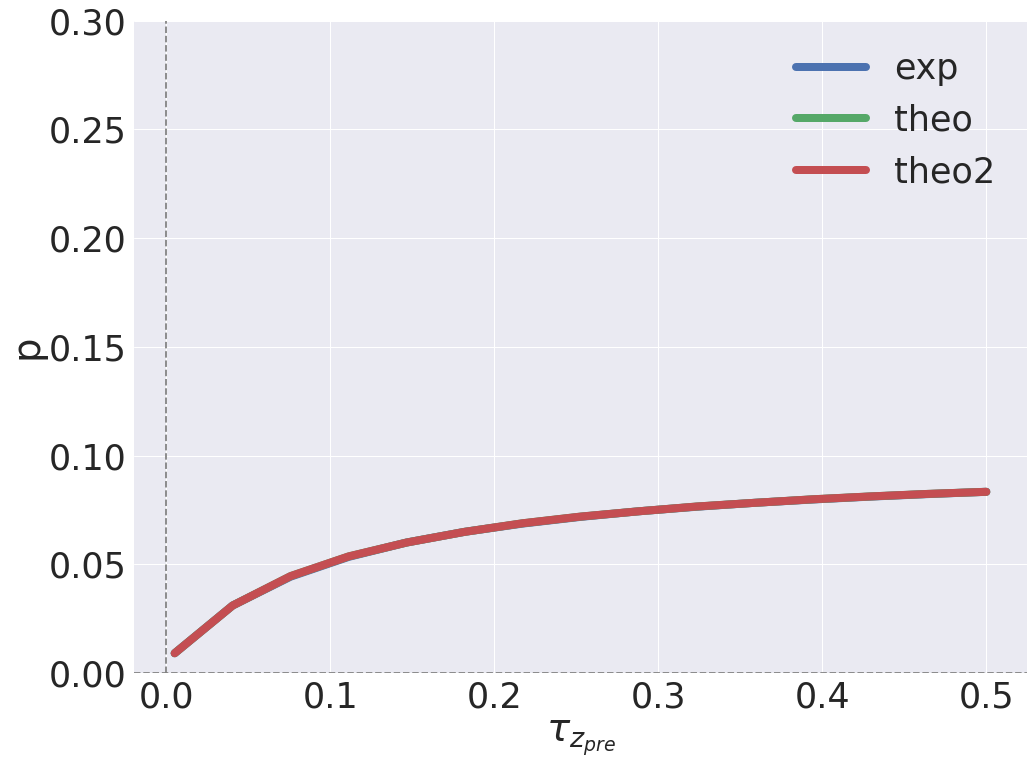

In [59]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(tau_z_vector, theo_p, lw=lw, ms=ms, label='theo')
ax.plot(tau_z_vector, theo_p2, lw=lw, ms=ms, label='theo2')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('p')

ax.set_ylim([0, 0.3])
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

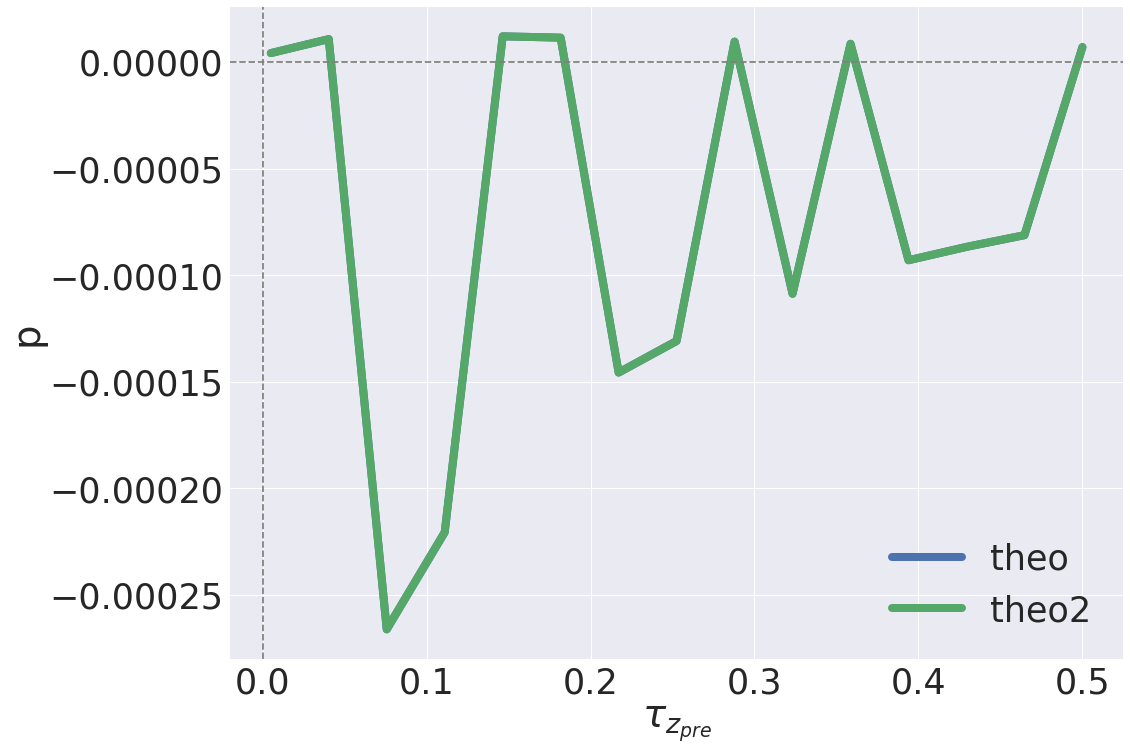

In [60]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')
ax.plot(tau_z_vector, normal_p - theo_p2, lw=lw, ms=ms, label='theo2')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('p')

ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

#### Training time

In [61]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 15
training_time_vector = np.linspace(0.020, 1.00, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, training_time_p in enumerate(training_time_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    training_time = [0.100 for i in range(n_patterns)]
    training_time[2] = training_time_p
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    Tp = training_time_p
    tau_z = tau_z_pre_ampa
    
    
    normal_p[index] = pi[2]
    theo_p[index] = single_p(Tp, Tt, tau_z)
    Tstart = 2 * training_time[0]
    theo_p2[index] = probability(tau_z, Tp, Tstart, Tt)

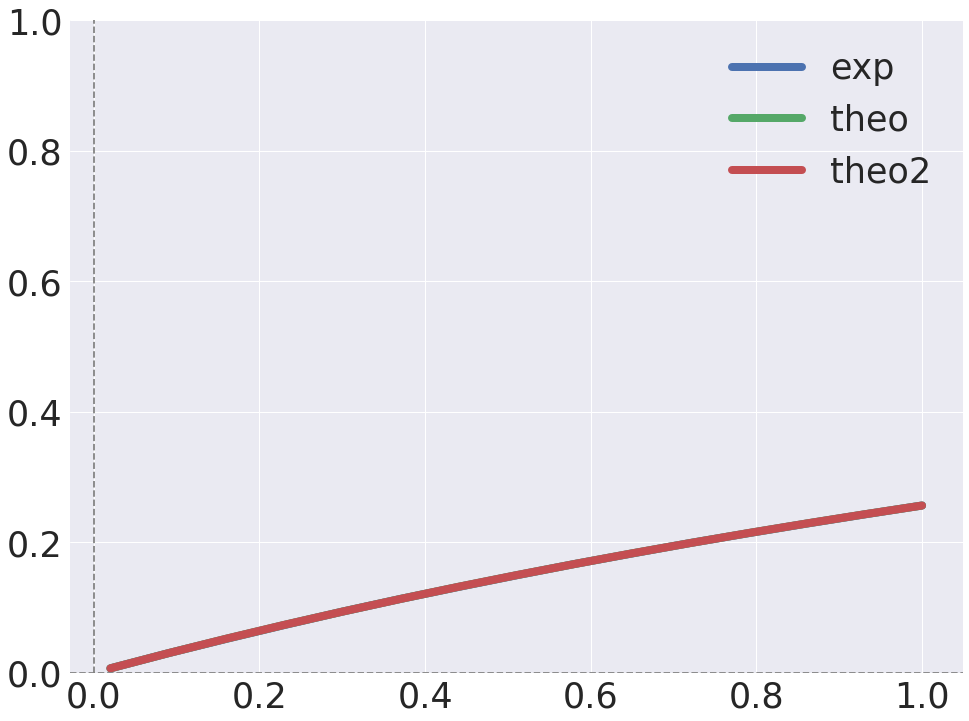

In [62]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(training_time_vector, theo_p, lw=lw, ms=ms, label='theo')
ax.plot(training_time_vector, theo_p2, lw=lw, ms=ms, label='theo2')

ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_ylim([0, 1.0])
ax.legend();

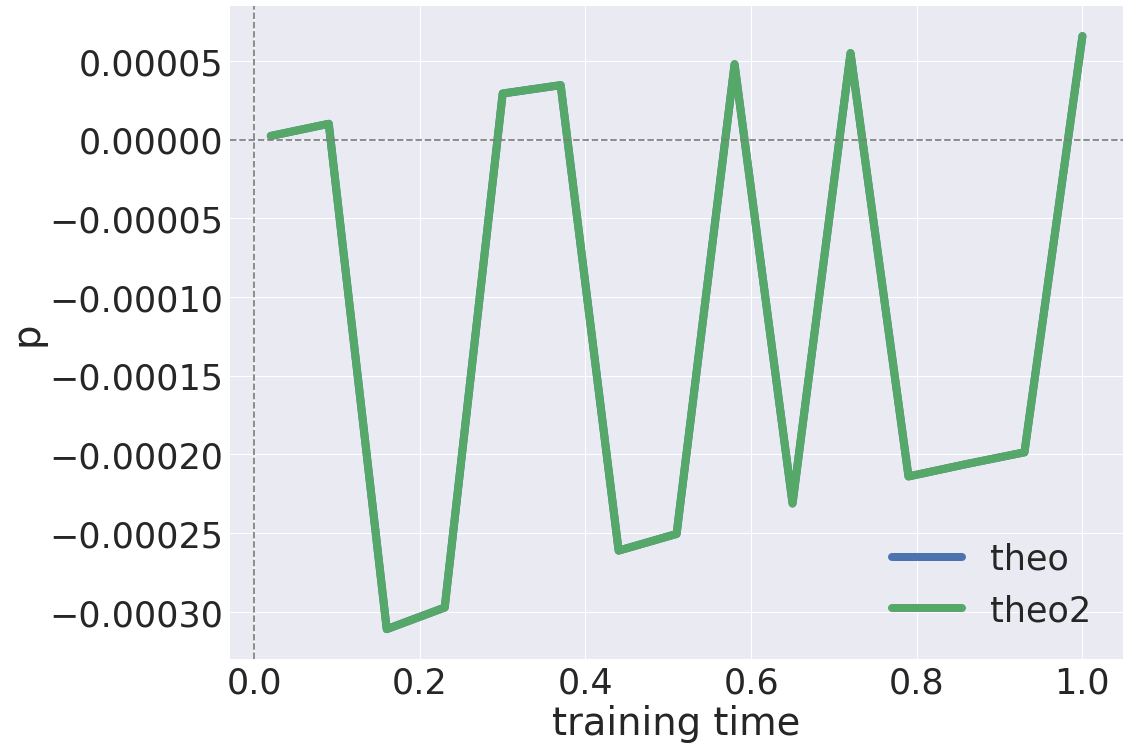

In [63]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')
ax.plot(training_time_vector, normal_p - theo_p2, lw=lw, ms=ms, label='theo2')


ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.legend();

In [66]:
1 / Tt

0.25641025641025644

## Joint probabilities

In [198]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 1.0
T_cue = 0.020

# Patterns parameters
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                  tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                  diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

nr = build_network_representation(matrix, minicolumns, hypercolumns)
timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_total, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

In [200]:
M1  = 1 - np.exp(-T1 / tau1)
M2 = 1 - np.exp(-T1 / tau2)
Mp = 1 - np.exp(-T1 / tau_p)

aux1 = T1 - tau1 * M1 - tau2 * M2 + tau_p * Mp
aux2 = tau_p * M1 * M2 * (1 - np.exp(-(Tt - T1)/tau_p))

P_self = aux1 + aux2

In [199]:
Tt = timed_input.T_total
T1 = training_time_p
Tt = timed_input.T_total
tau1 = tau_z_pre_ampa
tau2 = tau_z_post_ampa
p_aux = self_probability(T1, Tt, tau1, tau2)
p_aux

1.2381060962868622

In [201]:
aux1

1.9016258196404048

In [202]:
aux2

1.8126924692201818

In [203]:
tau_p

10.0

#### tau_z

In [170]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 30
tau_z_vector = np.linspace(0.005, 0.500, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, tau_z_pre_ampa in enumerate(tau_z_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)

    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    Tp = training_time
    tau_z = tau_z_pre_ampa
    T1 = training_time 
    T2 = training_time
    Ts = T1
    Tt = timed_input.T_total
    tau1 = tau_z_pre_ampa
    tau2 = tau_z_post_ampa
    p_aux = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)
    
    normal_p[index] = P[2, 1]
    theo_p[index] = p_aux

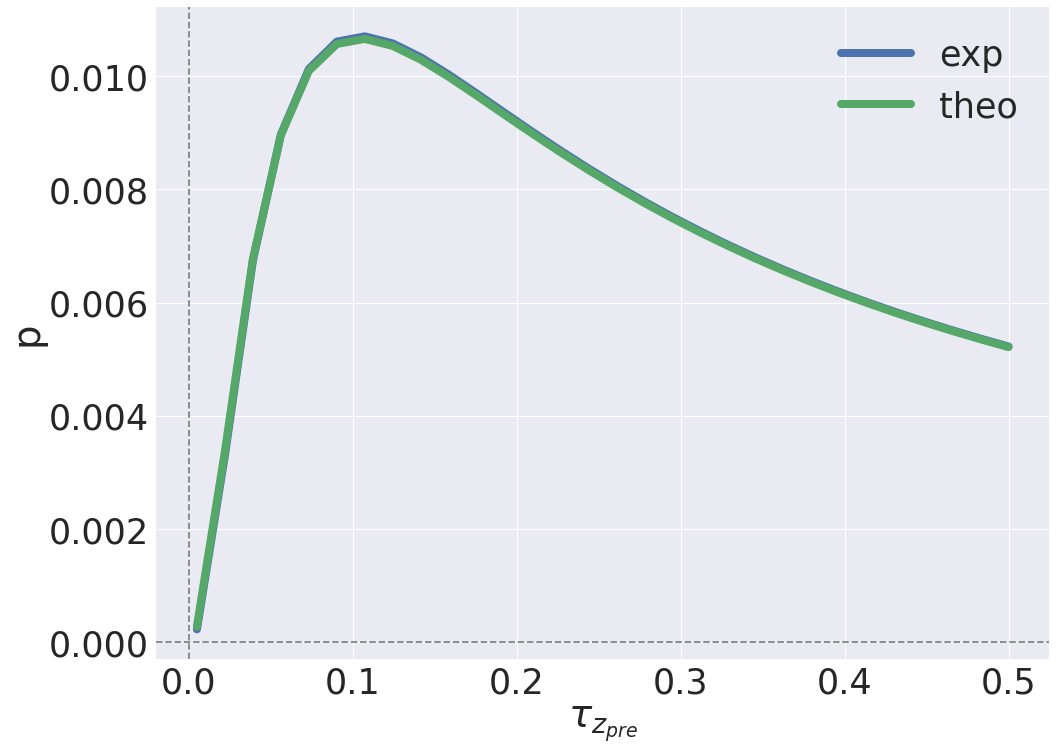

In [171]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(tau_z_vector, theo_p, lw=lw, ms=ms, label='theo')


ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('p')

# ax.set_ylim([0, 0.3])
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

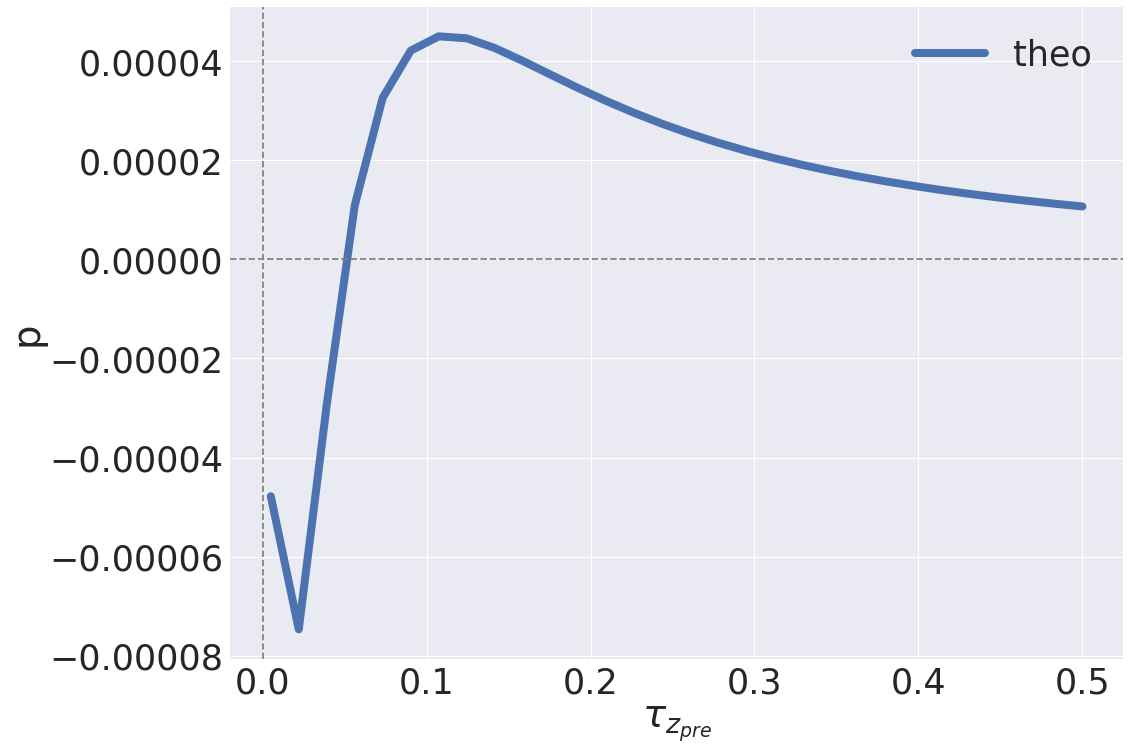

In [174]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')

ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('p')
ax.legend();

#### training time 1 (two big training times)

In [179]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 50
training_time_vector = np.linspace(0.020, 1.00, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, training_time_p in enumerate(training_time_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    training_time = [0.100 for i in range(n_patterns)]
    training_time[2] = training_time_p
    training_time[3] = training_time_p
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    T1 = training_time_p
    T2 = training_time_p
    Ts = T1
    Tt = timed_input.T_total
    tau1 = tau_z_pre_ampa
    tau2 = tau_z_post_ampa
    p_aux = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)
    
    normal_p[index] = P[3, 2]
    theo_p[index] = p_aux

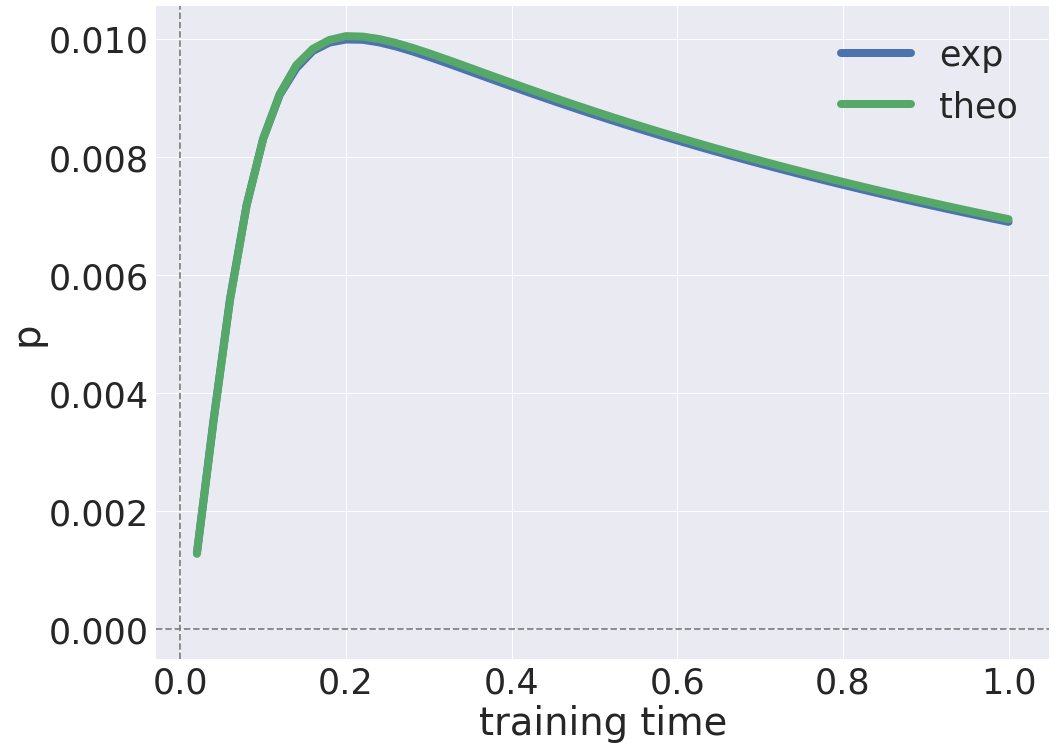

In [180]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(training_time_vector, theo_p, lw=lw, ms=ms, label='theo')

ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

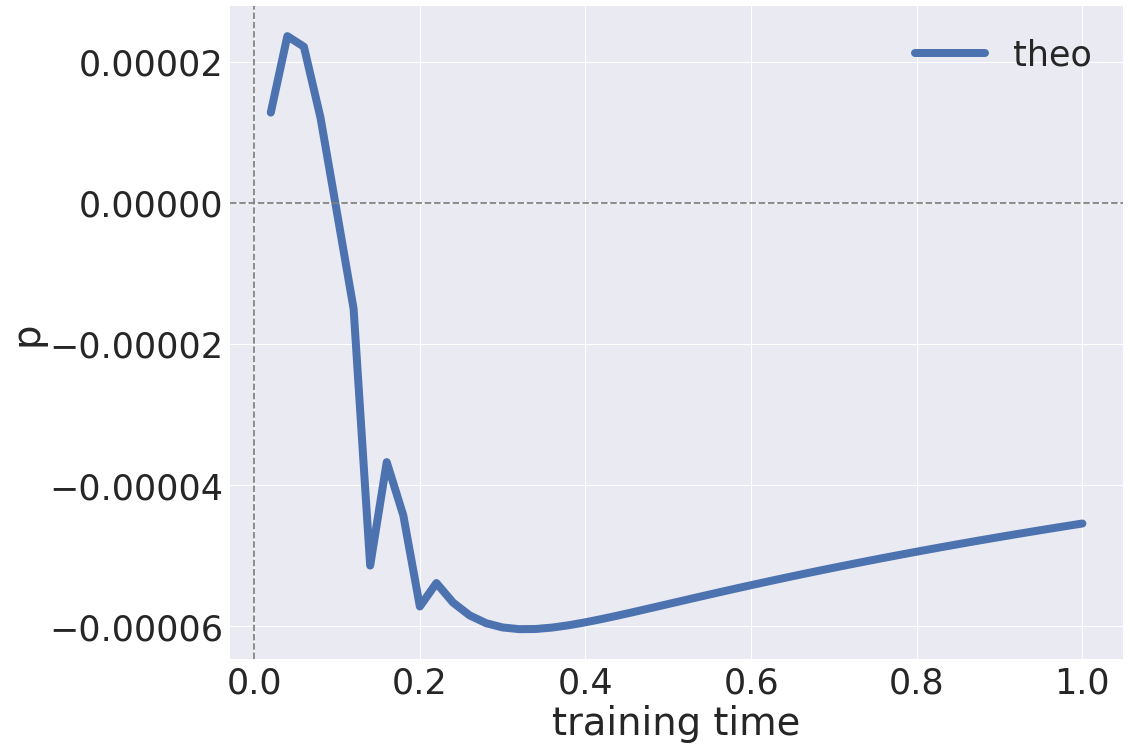

In [181]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')


ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.legend();

#### Training time 2 (one big the other small)

In [183]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 50
training_time_vector = np.linspace(0.020, 1.00, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, training_time_p in enumerate(training_time_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    training_time = [0.100 for i in range(n_patterns)]
    training_time[2] = training_time_p
    #training_time[3] = training_time_p
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    T1 = training_time_p
    T2 = 0.100
    Ts = T1
    Tt = timed_input.T_total
    tau1 = tau_z_pre_ampa
    tau2 = tau_z_post_ampa
    p_aux = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)
    
    normal_p[index] = P[3, 2]
    theo_p[index] = p_aux

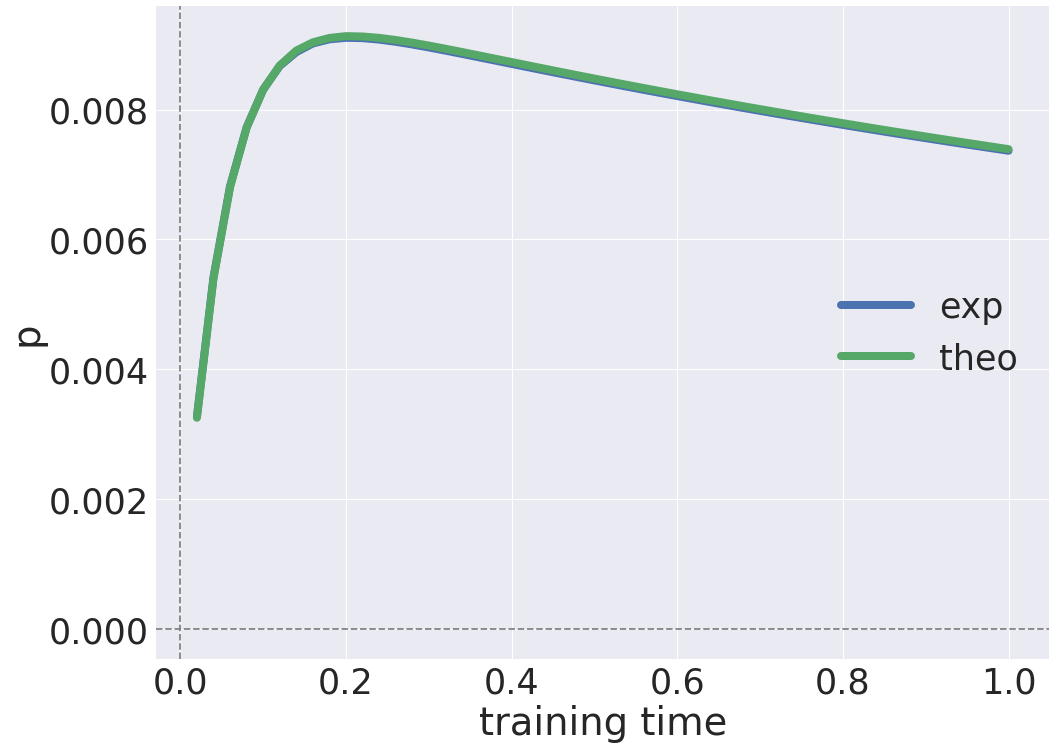

In [184]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(training_time_vector, theo_p, lw=lw, ms=ms, label='theo')

ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

In [ ]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')


ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.legend();

#### Training time self

In [205]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.050
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

num = 30
training_time_vector = np.linspace(0.020, 1.00, num=num)
normal_p = np.zeros(num)
theo_p = np.zeros(num)
theo_p2 = np.zeros(num)

for index, training_time_p in enumerate(training_time_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    training_time = [0.100 for i in range(n_patterns)]
    training_time[2] = training_time_p
    training_time[3] = training_time_p
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    
    Tt = timed_input.T_total
    T1 = training_time_p
    Tt = timed_input.T_total
    tau1 = tau_z_pre_ampa
    tau2 = tau_z_post_ampa
    p_aux = self_probability(T1, Tt, tau1, tau2)
    
    normal_p[index] = P[3, 3]
    theo_p[index] = p_aux

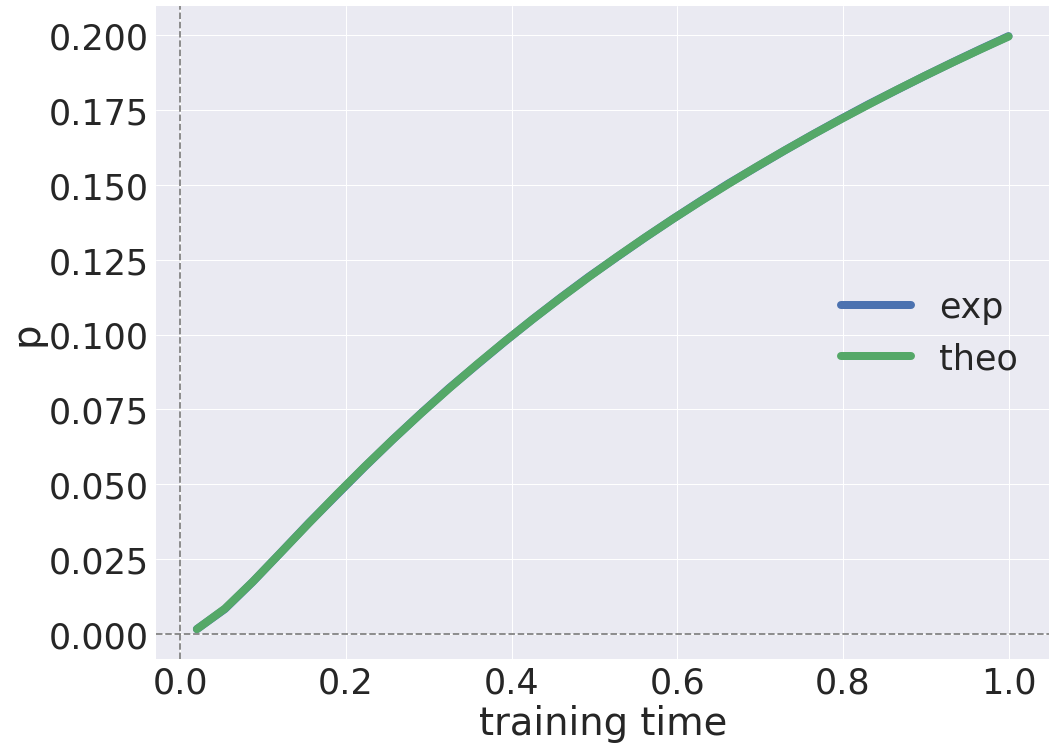

In [206]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p, lw=lw, ms=ms, label='exp')
ax.plot(training_time_vector, theo_p, lw=lw, ms=ms, label='theo')

ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();

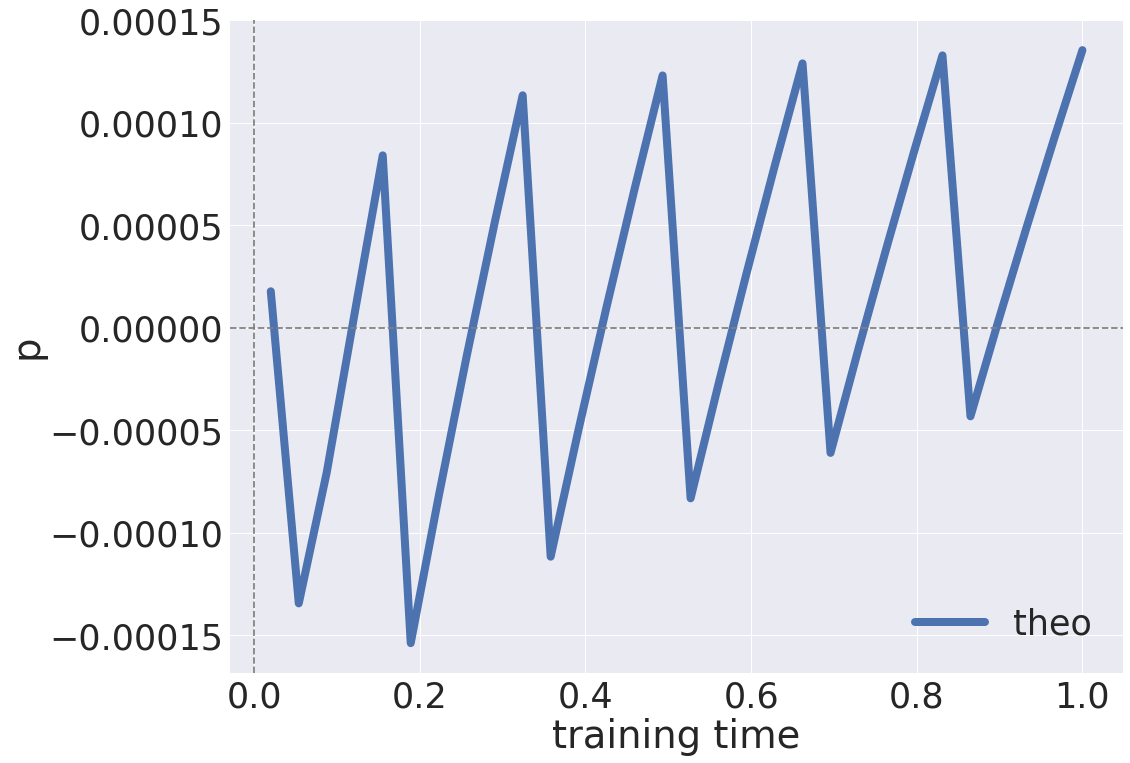

In [207]:
lw = 8
ms = 16

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_p - theo_p, lw=lw, ms=ms, label='theo')


ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.set_xlabel('training time')
ax.set_ylabel('p')
ax.legend();


## Connectivity matrix

In [228]:
# Manager properties
dt = 0.001

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
training_time = 0.100
minicolumns = 10
hypercolumns = 1

Tt = timed_input.T_total
T1 = training_time
T2 = training_time
Ts = T1
Tt = timed_input.T_total
tau1 = tau_z_pre_ampa
tau2 = tau_z_post_ampa
pij = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)
pji = joint_probabilities(T2, Ts, T1, Tt, tau2, tau1)
pii = self_probability(T1, Tt, tau1, tau2)

Ts  = 2 * training_time
pik = joint_probabilities(T1, Ts, T2, Tt, tau1, tau2)

Tp = T1
pi = single_p(Tp, Tt, tau1)
Tp = T2
pj = single_p(Tp, Tt, tau2)

Tp = training_time
pk = single_p(Tp, Tt, tau2)

w_self = np.log(pii / (pi * pi))
w_next = np.log(pij / (pi * pj))
w_rest = np.log(pij/(pi * pk))
w_back = np.log(pji/(pi * pj))
print(w_self, w_next, w_rest, w_back)
print(pii, pi, pj)

3.16185977592 1.7956105701 1.7956105701 -1.38629436524
0.0262383030484 0.0333333333333 0.0333333333333


In [229]:
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
training_time = [training_time for i in range(n_patterns)]
nr = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(nr, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)

S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)
print(w[1, 1])

1.37443712301


In [233]:
np.log10(P[1, 1] / pi[1] * pj[1])

-1.5795158085106107

In [232]:
pj[1]

0.033344448149383137

## Training time

In [252]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
g_beta = 1.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.
epochs = 1

num = 15
training_time_vector = np.linspace(0.020, 1.00, num=num)
normal_w_self = np.zeros(num)
theo_w_self = np.zeros(num)
normal_w_next = np.zeros(num)
theo_w_next = np.zeros(num)
normal_w_rest = np.zeros(num)
theo_w_rest = np.zeros(num)
normal_w_back = np.zeros(num)
theo_w_back = np.zeros(num)

for index, training_time_p in enumerate(training_time_vector):
    # Patterns parameters
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, 
                      tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=z_transfer, 
                      diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    training_time = [training_time_p for i in range(n_patterns)]
    training_time[2] = training_time_p
    nr = build_network_representation(matrix, minicolumns, hypercolumns)
    timed_input = TimedInput(nr, dt, training_time, 
                             inter_pulse_interval=inter_pulse_interval, 
                             inter_sequence_interval=inter_sequence_interval, 
                             epochs=epochs, resting_time=resting_time)

    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w, beta = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)

    Tt = timed_input.T_total
    T1 = training_time_p
    T2 = training_time_p
    tau1 = tau_z_pre_ampa
    tau2 = tau_z_post_ampa
    
    aux = get_weights_theo(T1, T2, Tt, tau1, tau2)
    w_self, w_next, w_rest, w_back = aux
    theo_w_self[index] = w_self
    normal_w_self[index] = w[1, 1]
    
    theo_w_next[index] = w_next
    normal_w_next[index] = w[2, 1]
    
    theo_w_rest[index] = w_rest
    normal_w_rest[index] = w[3, 1]
    
    theo_w_back[index] = w_back
    normal_w_back[index] = w[1, 2]

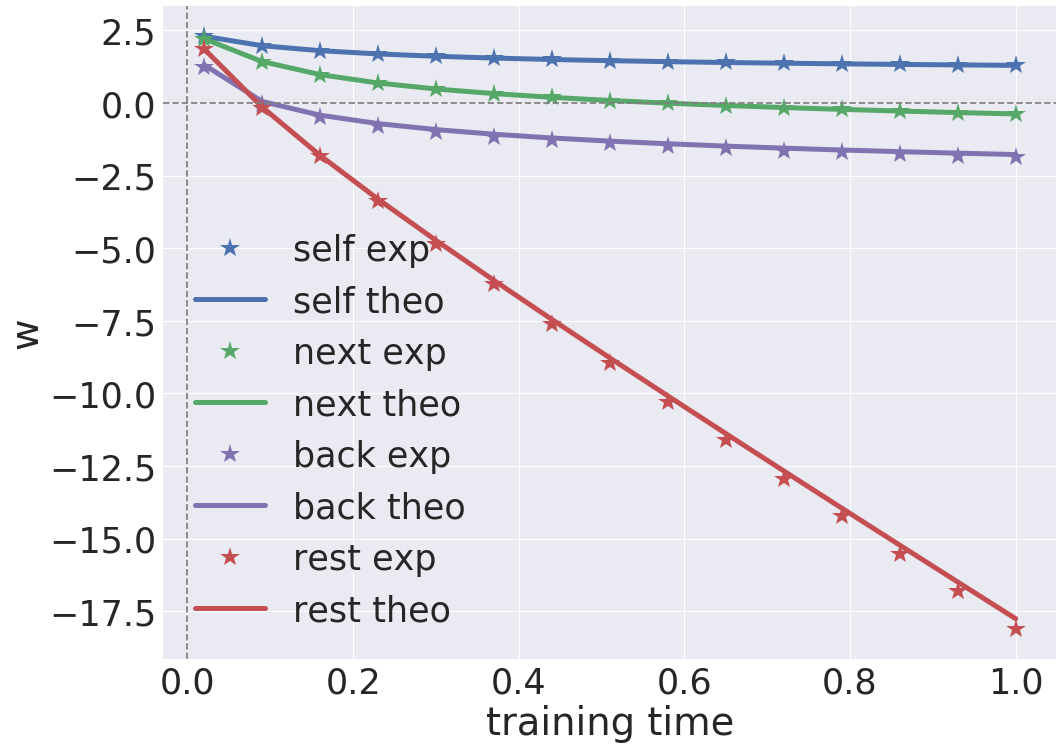

In [253]:
lw = 5
ms = 20
palette = sns.color_palette()


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(training_time_vector, normal_w_self, '*', color=palette[0], lw=lw, ms=ms, label='self exp')
ax.plot(training_time_vector, theo_w_self, '-', color=palette[0], lw=lw, ms=ms, label='self theo')

ax.plot(training_time_vector, normal_w_next, '*', color=palette[1], lw=lw, ms=ms, label='next exp')
ax.plot(training_time_vector, theo_w_next, '-', color=palette[1], lw=lw, ms=ms, label='next theo')

ax.plot(training_time_vector, normal_w_back, '*', color=palette[3], lw=lw, ms=ms, label='back exp')
ax.plot(training_time_vector, theo_w_back, '-', color=palette[3], lw=lw, ms=ms, label='back theo')

ax.plot(training_time_vector, normal_w_rest, '*', color=palette[2], lw=lw, ms=ms, label='rest exp')
ax.plot(training_time_vector, theo_w_rest, '-', color=palette[2], lw=lw, ms=ms, label='rest theo')


ax.set_xlabel('training time')
ax.set_ylabel('w')
ax.axhline(0, ls='--', color='gray');
ax.axvline(0, ls='--', color='gray')
ax.legend();